In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load your time series data
data = pd.read_csv('Truck_sales.csv', usecols=[1])

# # Convert the 'Day-Month' column to datetime, assuming the year is missing and should be inferred
# data['date'] = pd.to_datetime(data['Day-Month'], format='%d-%b', errors='coerce')
# data['date'] = data['date'].apply(lambda x: x.replace(year=2023))  # Replace year with the current year or appropriate year

# # Set the 'date' column as the index
# data.set_index('date', inplace=True)

# Extract the target variable
y = data['Number_Trucks_Sold']

In [3]:
print(y)

0      155
1      173
2      204
3      219
4      223
      ... 
139    933
140    704
141    639
142    571
143    666
Name: Number_Trucks_Sold, Length: 144, dtype: int64


In [4]:
y_train = y[:-12]
y_test = y[len(y_train)-1:]

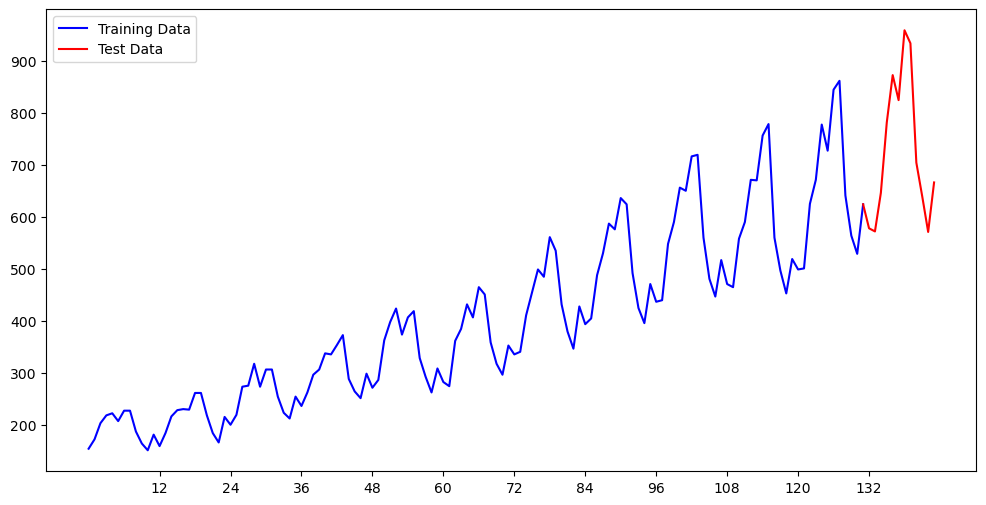

In [5]:
plt.figure(figsize=(12,6))
plt.plot(y_train, label='Training Data', color='blue')
plt.plot(range(131, 144), y_test, label='Test Data', color='red')
plt.legend()
plt.xticks([12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132])
plt.show()

In [6]:
# log_transform = np.log(y)
# plt.figure(figsize=(12,6))
# plt.plot(log_transform, label='Log-Transformed Data', color='blue')
# plt.show()

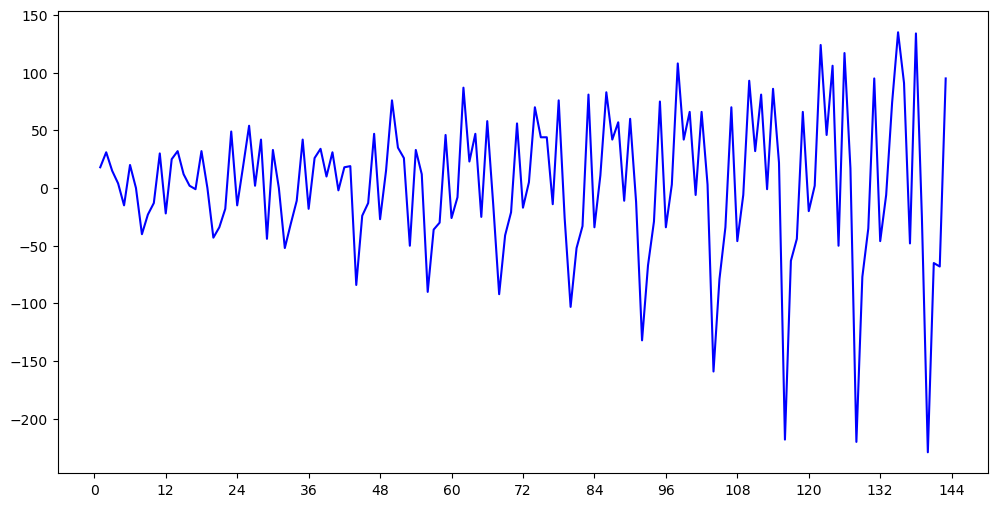

In [7]:
first_diff = y.diff()[1:]
plt.figure(figsize=(12,6))
plt.plot(first_diff, label='First-Order Differenced Data', color='blue')
plt.xticks([0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144])
plt.show()

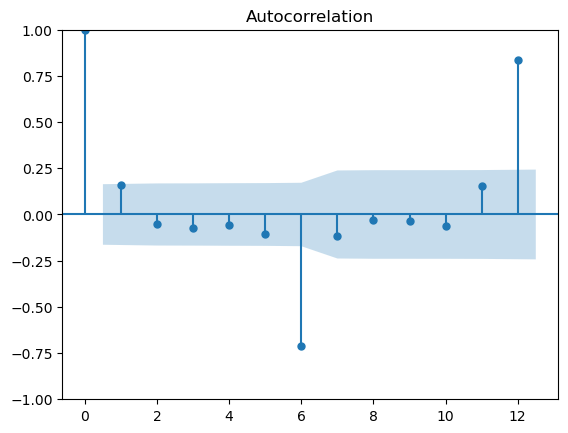

In [8]:
acf_plot = plot_acf(first_diff, lags=12)

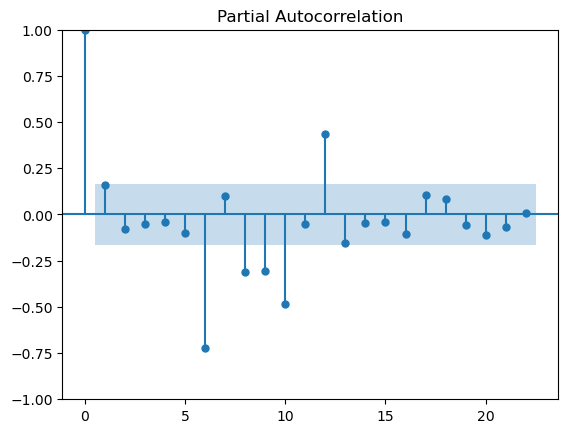

In [9]:
pacf_plot = plot_pacf(first_diff)

In [10]:
my_order = (1,1,0)
my_seasonal_order = (1, 0, 0, 12)

In [11]:
# Fit the SARIMA model
model = SARIMAX(y_train, order=my_order, seasonal_order=my_seasonal_order)
results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                 Number_Trucks_Sold   No. Observations:                  132
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -575.214
Date:                            Thu, 23 May 2024   AIC                           1156.428
Time:                                    15:01:39   BIC                           1165.054
Sample:                                         0   HQIC                          1159.933
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2054      0.081     -2.525      0.012      -0.365      -0.046
ar.S.L12       0.9690      0.017   

c:\Users\jessi\anaconda3\envs\use_this_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [12]:
predictions = results.predict(start=130, end=144, dynamic=False, signal_only=False, information_set='predicted')
predictions = predictions
predictions = pd.Series(predictions, index=y_test.index)
residuals = y_test - predictions

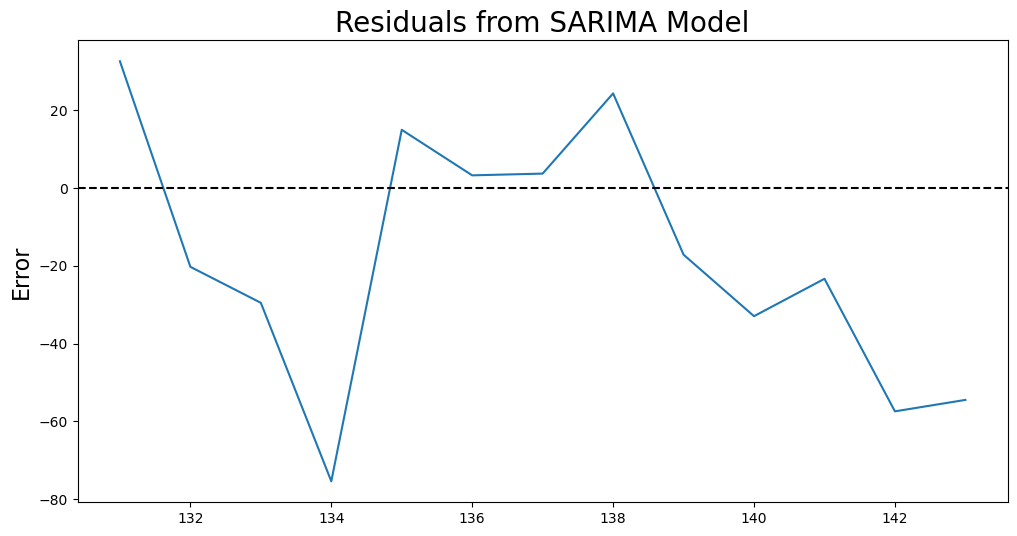

In [13]:
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.show()

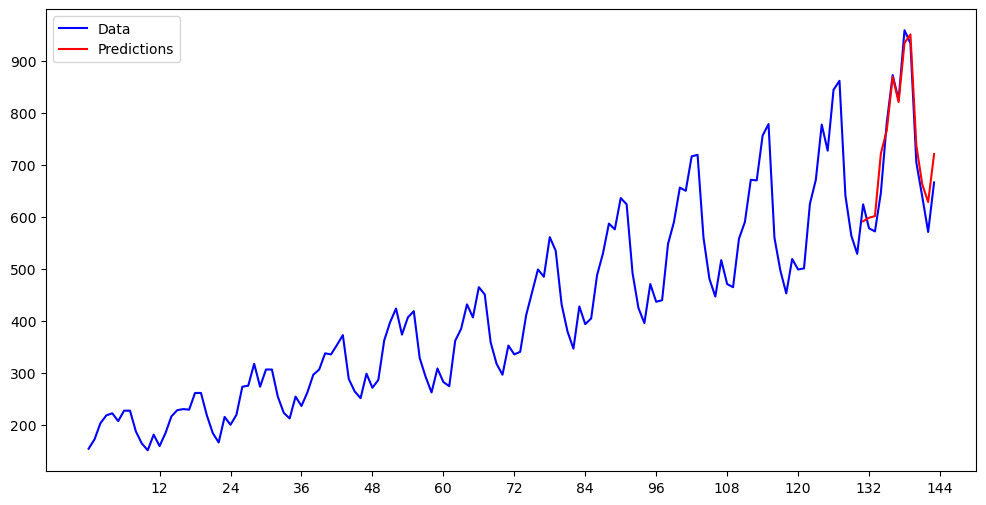

In [14]:
plt.figure(figsize=(12,6))
plt.plot(y, label='Data', color='blue')
plt.plot(range(131, 144), predictions, label='Predictions', color='red')
plt.xticks([12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144])
plt.legend()
plt.show()

In [15]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/y_test)),4))

Mean Absolute Percent Error: 0.0456


### Rolling Forecast

In [16]:
rolling_predictions = y_test.copy()
for train_end in y_test.index:
    train_data = y[:train_end-1]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    results = model.fit()
    prediction = results.forecast()
    rolling_predictions[train_end] = prediction

c:\Users\jessi\anaconda3\envs\use_this_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\jessi\AppData\Local\Temp\ipykernel_50600\2382845921.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[524.7251426]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rolling_predictions[train_end] = prediction
c:\Users\jessi\anaconda3\envs\use_this_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\jessi\AppData\Local\Temp\ipykernel_50600\2382845921.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise

In [17]:
rolling_residuals = y_test - rolling_predictions

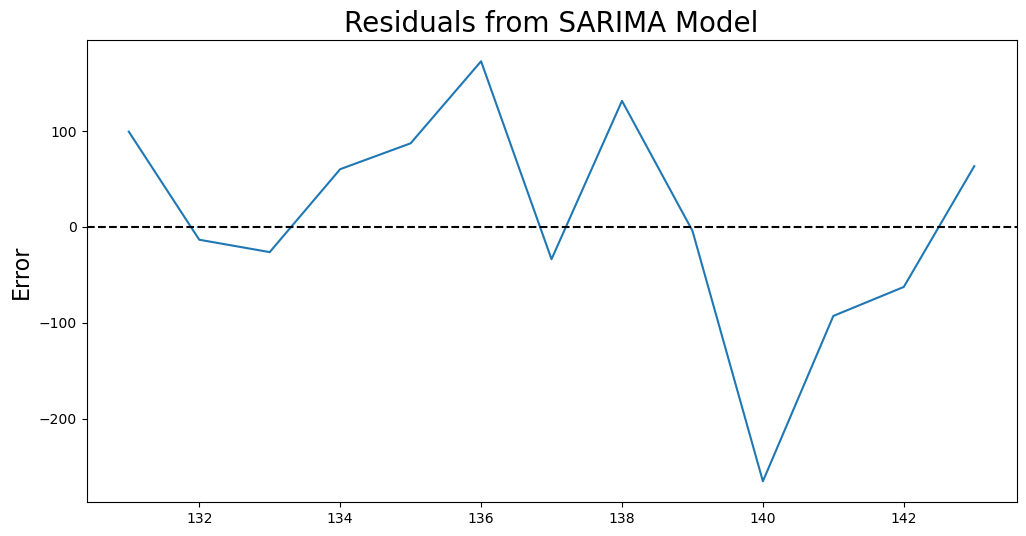

In [18]:
plt.figure(figsize=(12,6))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.show()

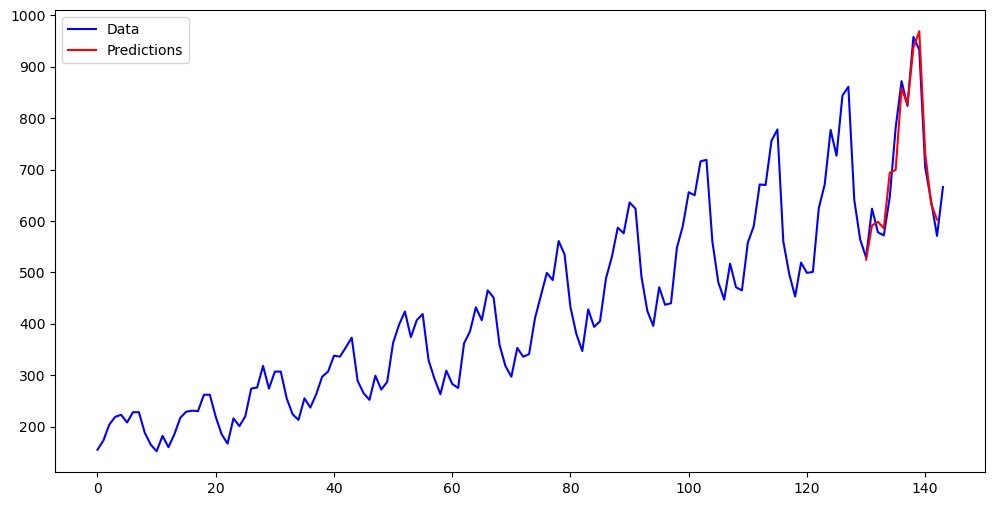

In [19]:
plt.figure(figsize=(12,6))
plt.plot(y, label='Data', color='blue')
plt.plot(range(130,143), rolling_predictions, label='Predictions', color='red')
plt.legend()
plt.show()

In [20]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/y_test)),4))

Mean Absolute Percent Error: 0.1184
